In [1]:
!pip install wfdb==4.3.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.9/89.9 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.1/13.1 MB 69.1 MB/s eta 0:00:00
  Attempting uninstall: pandas
    Found existing installation: pandas 2.2.2
    Uninstalling pandas-2.2.2:
      Successfully uninstalled pandas-2.2.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.2.3 which is incompatible.


In [2]:
!wget -r -N -c -np https://physionet.org/files/mitdb/1.0.0/

Streaming output truncated to the last 5000 lines.
Length: 5468 (5.3K) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.atr’

physionet.org/files 100%[===================>]   5.34K  --.-KB/s    in 0s      

2025-05-20 16:31:04 (1.03 GB/s) - ‘physionet.org/files/mitdb/1.0.0/223.atr’ saved [5468/5468]

--2025-05-20 16:31:04--  https://physionet.org/files/mitdb/1.0.0/223.dat
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 1950000 (1.9M) [application/octet-stream]
Saving to: ‘physionet.org/files/mitdb/1.0.0/223.dat’

physionet.org/files 100%[===================>]   1.86M   430KB/s    in 4.4s    

2025-05-20 16:31:09 (436 KB/s) - ‘physionet.org/files/mitdb/1.0.0/223.dat’ saved [1950000/1950000]

--2025-05-20 16:31:09--  https://physionet.org/files/mitdb/1.0.0/223.hea
Reusing existing connection to physionet.org:443.
HTTP request sent, awaiting response... 200 OK
Length: 258 [text/plain]
Saving to: ‘physionet.

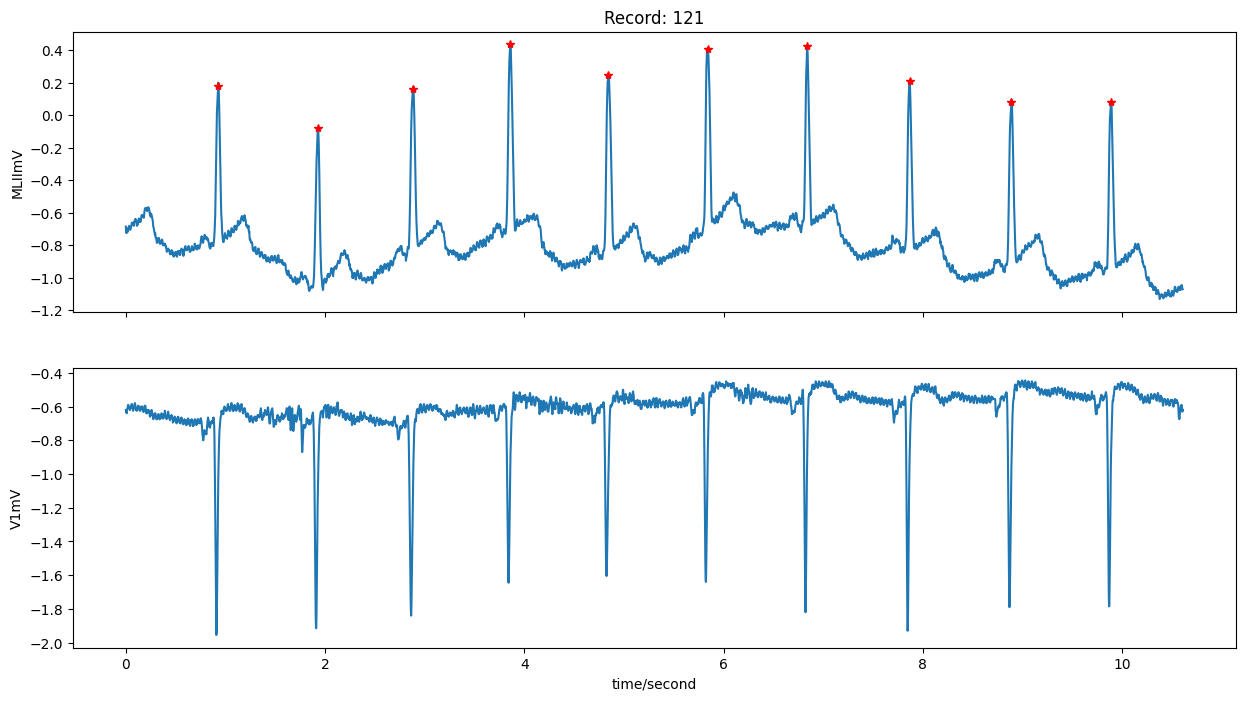

In [22]:
import wfdb
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import find_peaks

file = "/content/physionet.org/files/mitdb/1.0.0/121"
record = wfdb.rdrecord(file, sampfrom = 180, sampto= 4000,)
annotation = wfdb.rdann(file, 'atr', sampfrom=180, sampto=4000,shift_samps=True)
wfdb.plot_wfdb(record=record, annotation=annotation, time_units='seconds',figsize=(15,8))

In [37]:
class Pan_Tompkins_Algorithm():
  def __init__(self, signal, fs):
    self.signal = signal.astype(np.float32)
    self.fs = fs
    self.filtered_signal = None

  def low_pass_filter(self):
    '''
    The recursive low-pass filter function.
    y(n) = 2*y(n-1) - y(n-2) + 1/32(x(n) -2x(n-6) + x(n-12))
    '''
    x = self.signal.copy()
    y = np.zeros_like(x)

    for n in range(len(x)):
      input_n = x[n]
      if n >= 6:
        input_n -= 2*x[n -6]
      if n >= 12:
        input_n += x[n -12]
      input_n *= 1/32

      output_n = 0
      if n >= 1:
        output_n = 2*y[n -1]
      if n >= 2:
        output_n -= y[n -2]
      y[n] = output_n + input_n

    return y

  def high_pass_filter(self, y):
    '''
    It is implemented as an all pass filter minus a low pass filter
    Step 1: y(n) = y(n-1) + x(n) - x(n-32)
    Step 2: z(n) = x(n - 16) - (1/32) * y(n)
    '''
    x = self.signal.copy()
    p = np.zeros_like(x)

    for n in range(len(x)):
      if n >= 32:
        y[n] = y[n -1] + x[n] - x[n -32]
      elif n >= 1:
        y[n] = y[n-1] + x[n]
      else:
        y[n] = x[n]

      if n >= 16:
        p[n] = x[n -16] - (1/32)*y[n]
      else:
        p[n] = -(1/32)*y[n]

    return p

  def band_pass_filter(self):
    low_pass_filtered_signal = self.low_pass_filter()
    band_pass_filtered_signal = self.high_pass_filter(low_pass_filtered_signal.copy())
    maxVal = max(abs(np.max(band_pass_filtered_signal)), abs(np.min(band_pass_filtered_signal)))
    return band_pass_filtered_signal/maxVal

  def derivative(self, y):
    '''
    The derivative procedure suppresses the low frequency components of P&T waves,
    and provides a large gain to the high frequency components arisimg from the high
    slopes of QRS complexes.
    y(n) = 1/8(2*x(n) + x(n-1) - x(n-3) - 2*x(n-4))
    '''
    x = self.signal.copy()

    for n in range(len(x)):
      val = 0
      if n >= 0:
        val += 2*x[n]
      if n >= 1:
        val += x[n -1]
      if n >= 3:
        val -= x[n -3]
      if n >= 4:
        val -= 2*x[n -4]
      val *= 1/8

      y[n] = val

    return y

  def sqauring(self, y):
    '''
    The sqaurring operation makes the result positive and emphasizes large differences
    resulting from QRS complexes. The small differences arising from P and T waves are
    suppressed.
    y(n) = x(n)^2
    '''
    for n in range(len(y)):
      y[n] = y[n] ** 2

    return y

  def integrate(self, y):
    '''
    The output of the derivative operation will exhibit multiple peaks.
    By this it will smooth it out.
    Moving Window Integration of signal x.
    y(n) = (1/N) * sum_{i=0}^{N-1} x(n - i)
    '''
    # window_size = round(0.150*self.fs)
    window_size = 30
    result = np.zeros_like(y, dtype=np.float64)

    # Initialize running sum
    running_sum = 0.0

    # First window (partial fill)
    for j in range(window_size):
        running_sum += y[j]
        result[j] = running_sum / (j + 1)

    # Full sliding window
    for i in range(window_size, len(y)):
        running_sum += y[i] - y[i - window_size]
        result[i] = running_sum / window_size

    return result

  def run(self):
    global bpf
    bpf = self.band_pass_filter()
    global der
    der = self.derivative(bpf.copy())
    global sqr
    sqr = self.sqauring(der.copy())
    global inte
    inte = self.integrate(sqr.copy())

timestamps = np.arange(len(record.adc()))
ecg_signal = record.adc()[:, 0]

ecg = pd.DataFrame(np.column_stack((timestamps, ecg_signal)), columns=['TimeStamp', 'ecg'])

print(ecg.columns)
QRS_Detector = Pan_Tompkins_Algorithm(ecg['ecg'], annotation.fs)
QRS_Detector.run()

Index(['TimeStamp', 'ecg'], dtype='object')


Text(0.5, 1.0, 'Moving Window Integrated Signal')

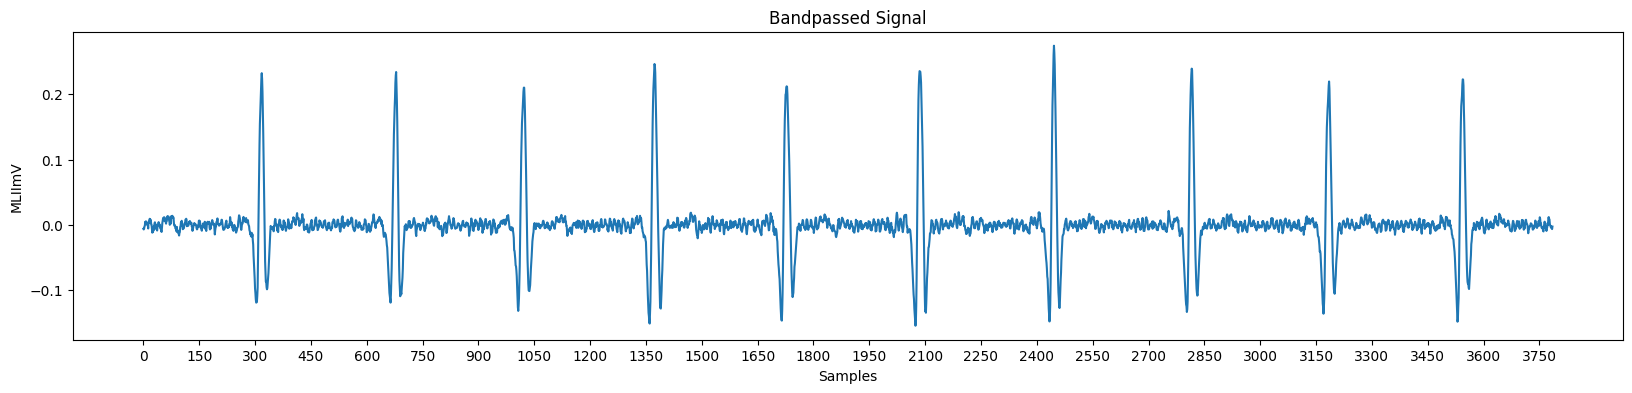

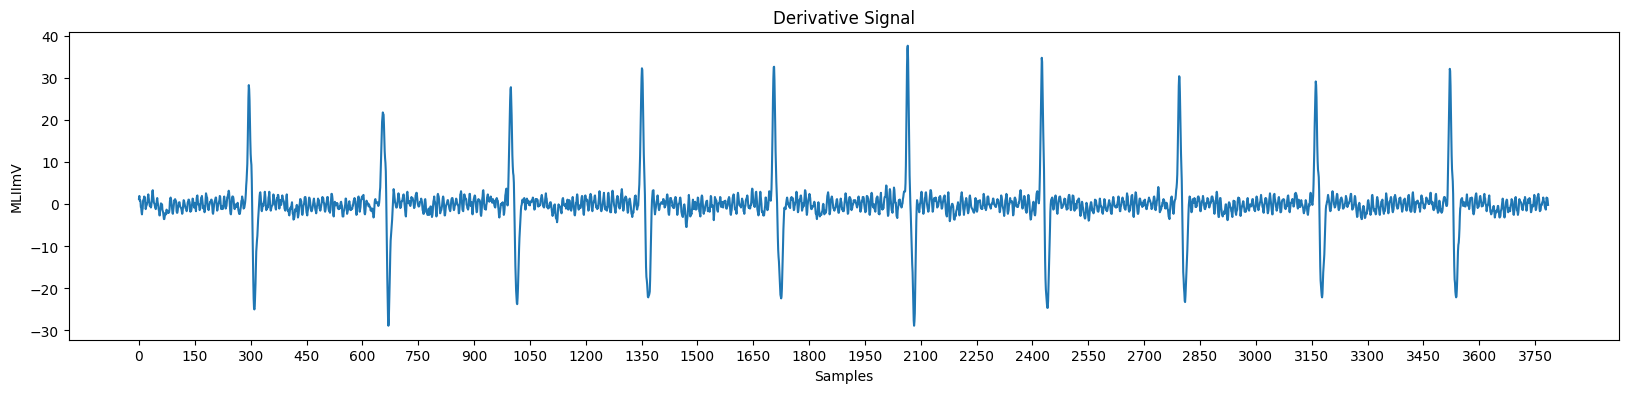

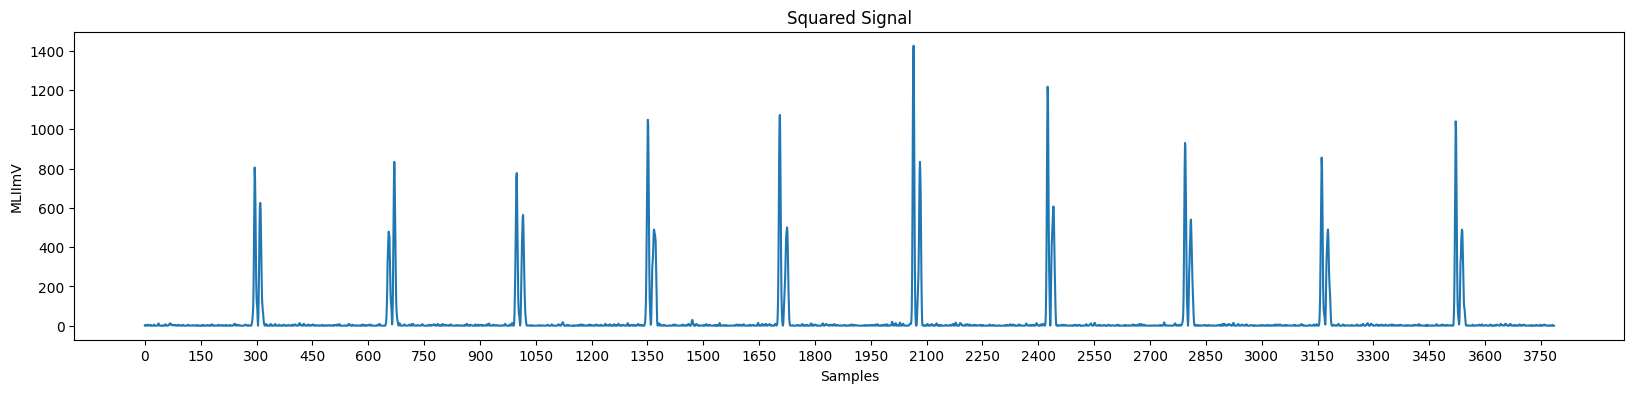

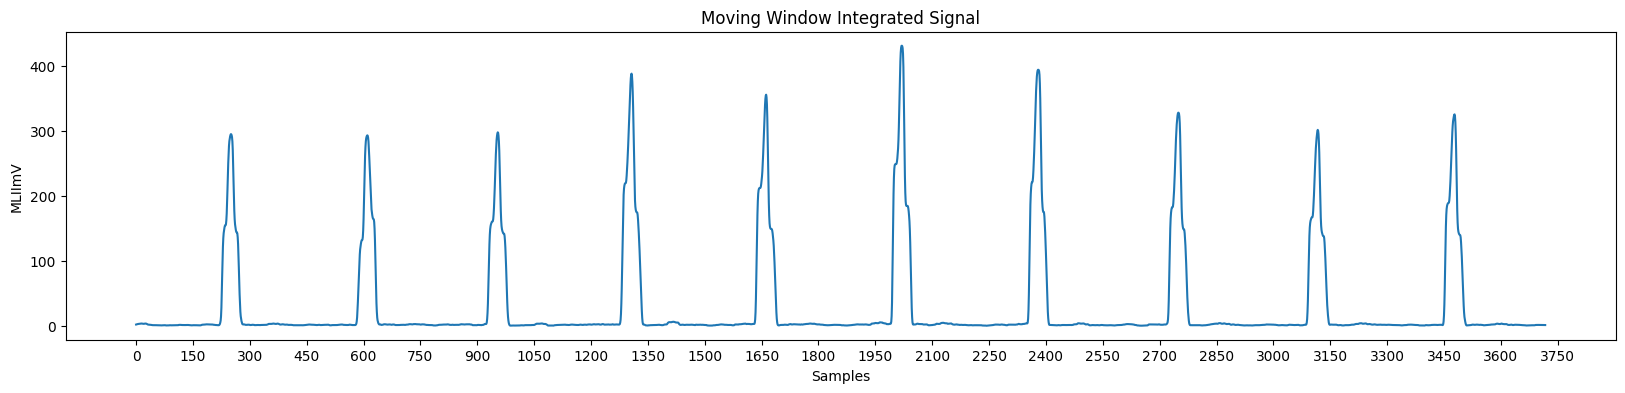

In [38]:
# Plotting bandpassed signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(bpf)+1, 150))
plt.plot(bpf[32:len(bpf)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Bandpassed Signal")

# Plotting derived signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(der)+1, 150))
plt.plot(der[32:len(der)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Derivative Signal")

# Plotting squared signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(sqr)+1, 150))
plt.plot(sqr[32:len(sqr)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Squared Signal")

# Plotting moving window integrated signal
plt.figure(figsize = (20,4), dpi = 100)
plt.xticks(np.arange(0, len(inte)+1, 150))
plt.plot(inte[100:len(inte)-2])
plt.xlabel('Samples')
plt.ylabel('MLIImV')
plt.title("Moving Window Integrated Signal")